Project workflow:

* Import Libraries
* Load Data
* Data Cleaning
* EDA
* Data/Text Preprocessing
* Model Building (Model Training)
* Model Evaluation
* Model Improvement
* Website for Model Deployment
* Deploy Model

### Importing  Libraries and Loading Data

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import re
from wordcloud import WordCloud
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer

# model building
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

import pickle


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# loading data
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['spam.csv']), encoding='latin-1')
df.sample(5)

Saving spam.csv to spam.csv


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
944,ham,I sent my scores to sophas and i had to do sec...,NaN,NaN,NaN
876,ham,Are you in castor? You need to see something,NaN,NaN,NaN
1106,ham,"Good afternoon, my love. How goes your day ? W...",NaN,NaN,NaN
131,ham,"Dear, will call Tmorrow.pls accomodate.",NaN,NaN,NaN
3739,ham,No da. . Vijay going to talk in jaya tv,NaN,NaN,NaN


### Data Introduction

In [5]:
df.shape

(5572, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


### Data Cleaning

In [7]:
df.columns



Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [8]:
#drop last 3 columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
#rename firt 2 columns
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)

In [9]:
# missing values
df.isnull().sum()


,0
target,0
text,0


In [10]:
# duplicates
df.duplicated().sum()

403

In [11]:
# remove duplicates
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

In [12]:
df.shape

(5169, 2)

In [13]:
# encoding target column
encoder = LabelEncoder()

df['target'] = encoder.fit_transform(df['target'])
df.head()

<ipython-input-13-ce624b31e223>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = encoder.fit_transform(df['target'])


,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### EDA

Checking if the data is imbalanced or not.

In [14]:
df['target'].value_counts()

,count
target,
0,4516
1,653


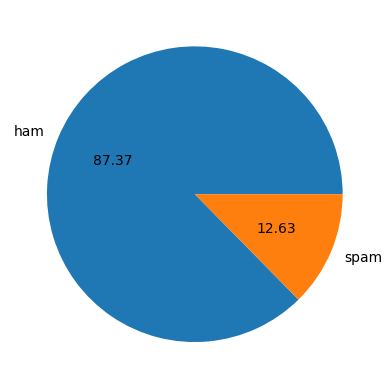

In [15]:
plt.pie(df['target'].value_counts(), labels=['ham','spam'], autopct="%0.2f")
plt.show()

Above figure shows data is imbalanced. Most of the emails in dataset (87.37%) are non-spam (ham), while only a smaller portion (12.63%) are classified as spam. Since there are more non-spam emails, the model might become biased and miss some spam emails.

In [16]:
# creating new feature columns
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [17]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [18]:
#ham
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


This summary indicates Non-spam emails have an average of about 79 characters, 18 words, and nearly 2 sentences per entry.

In [19]:
#spam
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


This summary shows that Spam emails have an average of about 138 characters, 28 words, and nearly 3 sentences per entry.

<Axes: xlabel='num_characters', ylabel='Count'>

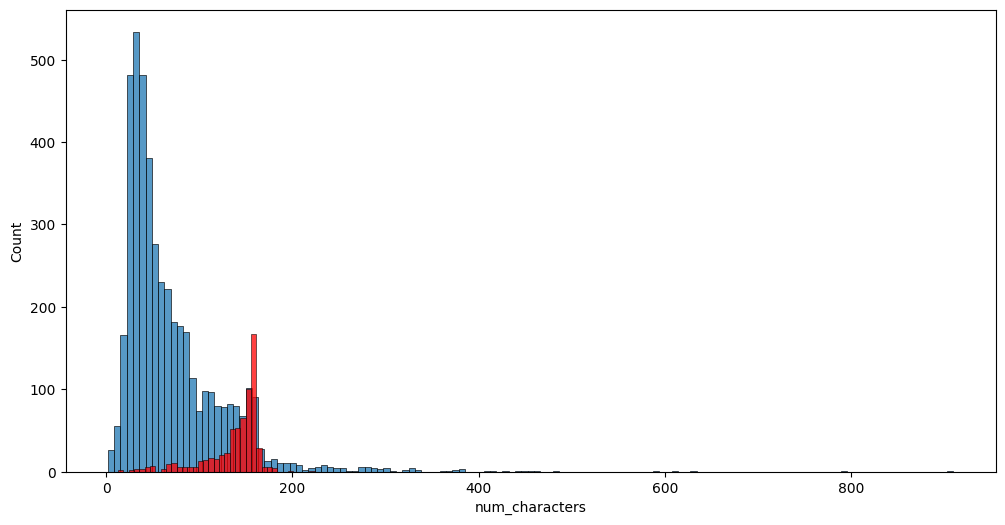

In [20]:
# distribution of number of characters in Ham and Spam sms
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] ==0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'], color='red')

Number of characters used in Spam sms are more as compared to Non-Spam sms.

<Axes: xlabel='num_words', ylabel='Count'>

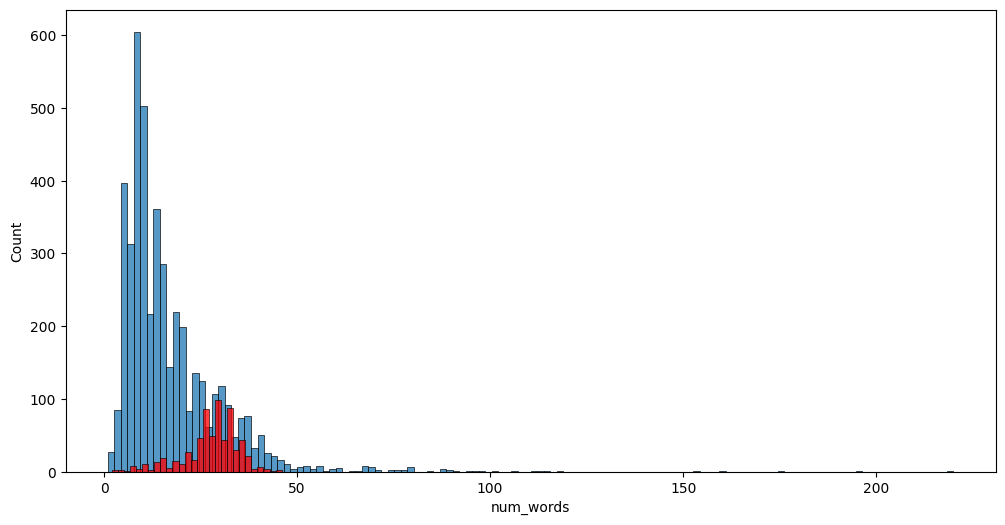

In [21]:
# distribution of number of words in Ham and Spam sms
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'], color='red')

Above plot shows that most of the time Non-Spam sms (Ham) are composed of less words as compared to Spam sms. Although we have few outlies as well, few Non-Spam sms (Ham) are lengthy as well.

<Axes: xlabel='num_sentences', ylabel='Count'>

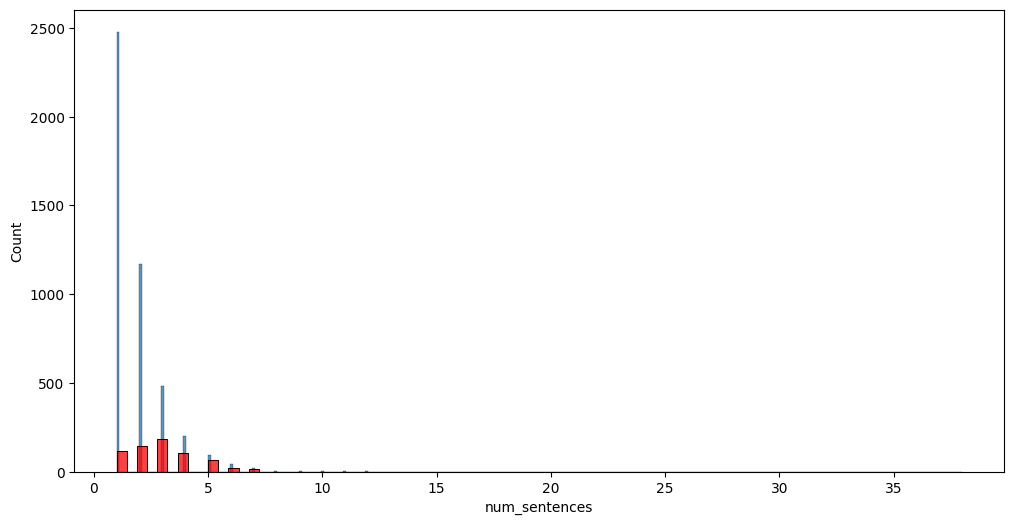

In [22]:
# distribution of number of sentences in Ham and Spam sms
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_sentences'])
sns.histplot(df[df['target'] == 1]['num_sentences'], color='red')

Above plot shows that most of the Non-Spam sms (Ham) are composed of less sentences as compared to Spam sms.

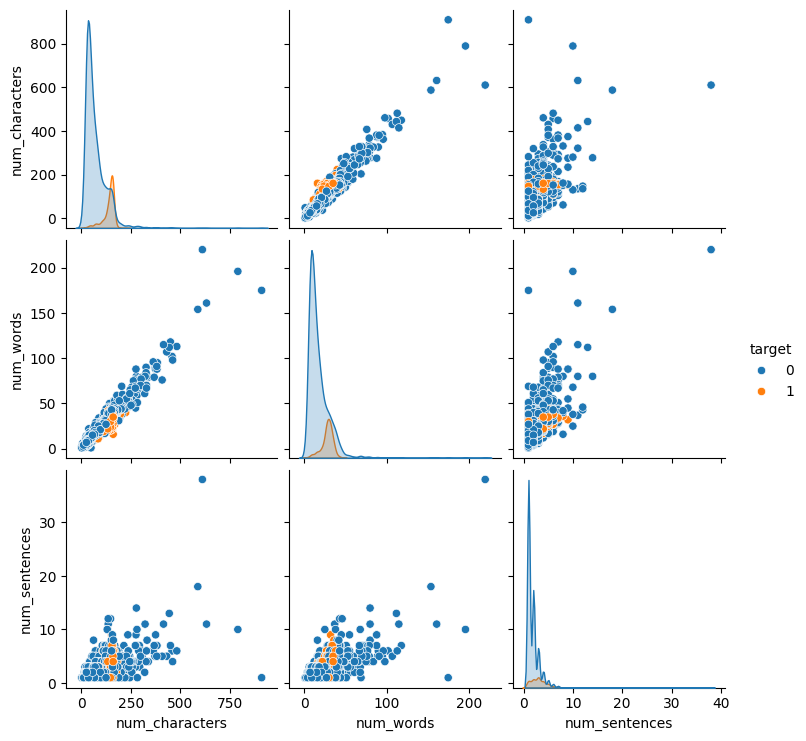

In [23]:
# pairplot to visualize the relationships between multiple columns
sns.pairplot(df,hue='target')

From the pair plot, we can see a few outliers all in the class ham. This is interesting as we could put a cap over one of these. As they essentially indicate the same thing ie the length of SMS.

In [24]:
#Dropping the outliers.
df = df[(df["num_characters"]<350)]
df.shape

(5149, 5)

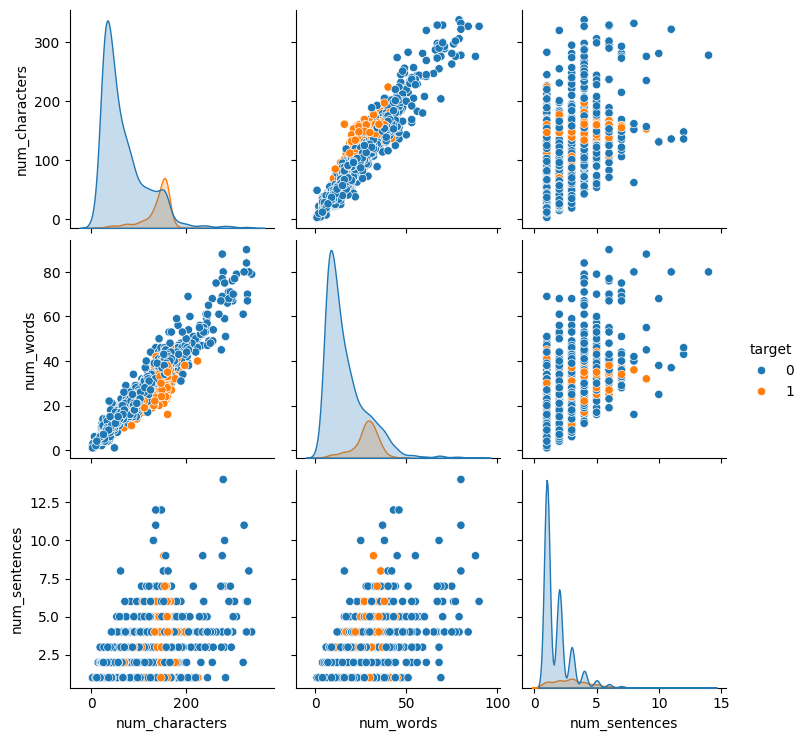

In [25]:
# pairplot after removing outliers to visualize the relationships between multiple columns
sns.pairplot(df,hue='target')

The Relationship between Features is
                 num_characters  num_words  num_sentences
num_characters        1.000000   0.962604       0.608213
num_words             0.962604   1.000000       0.646488
num_sentences         0.608213   0.646488       1.000000


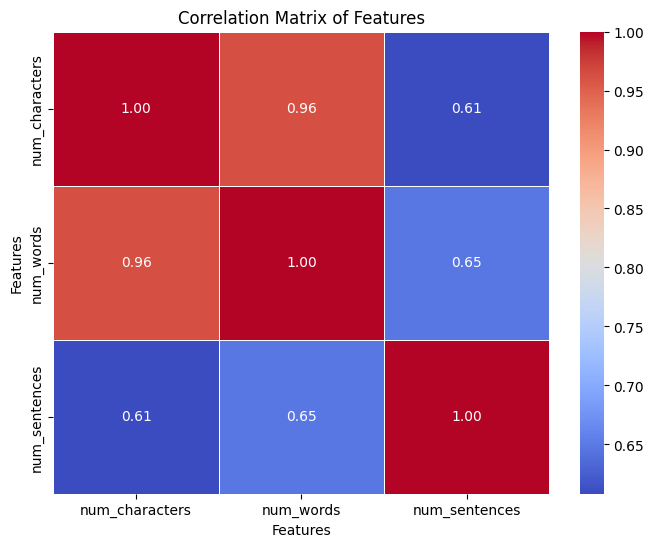

In [26]:
# visualize the correlation matrix using a heatmap
correlation_matrix = df[['num_characters','num_words','num_sentences']].corr()
print("The Relationship between Features is\n",correlation_matrix )

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

### Data Preprocessing:


1. Lower case
2. Tokenization
3. Removal of special characters
4.  Removal of stop words and punctuation
5.  Stemming

In [27]:
stopwords.words('english')
string.punctuation

ps = PorterStemmer()

In [28]:
# Function to preprocess text
"""
Steps:
Removal of special characters
Lower case
Tokenization
Removal of stop words and punctuation
Stemming

"""
def transform_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text) # replacing all non-alphabetic characters with a space
    text = text.lower() # converting to lowecase
    text = nltk.word_tokenize(text) # to split a string into individual words (tokens)

    filtered_text = []
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation: # removal of stop words and punctuation
           filtered_text.append(ps.stem(i)) # Stemming

    return " ".join(filtered_text)


Stemming is the process of getting the root form of a word. Stem or root is the part to which inflectional affixes are added. The stem of a word is created by removing the prefix or suffix of a word.

In [29]:
# testing above function
w = df['text'][10]
transform_text(w)

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [30]:
# add transformed text to dataframe
df['transformed_text'] = df['text'].apply(transform_text)
df.head()

<ipython-input-30-587f96f81cea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transformed_text'] = df['text'].apply(transform_text)


,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri wkli comp win fa cup final tkt st m...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


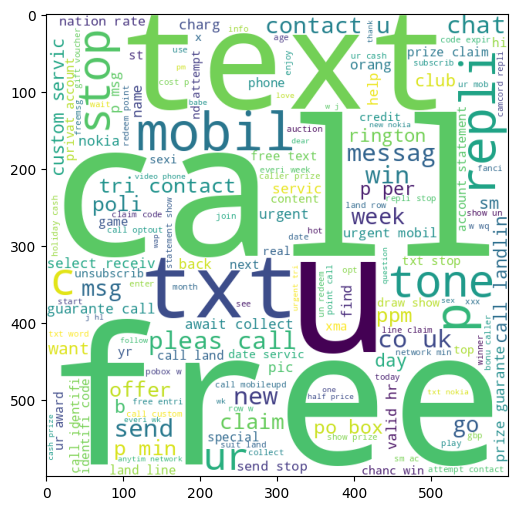

In [31]:
# visualizing the words for spam texts through word cloud
wc = WordCloud(width=600,height=600,min_font_size=10,background_color='white')

spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

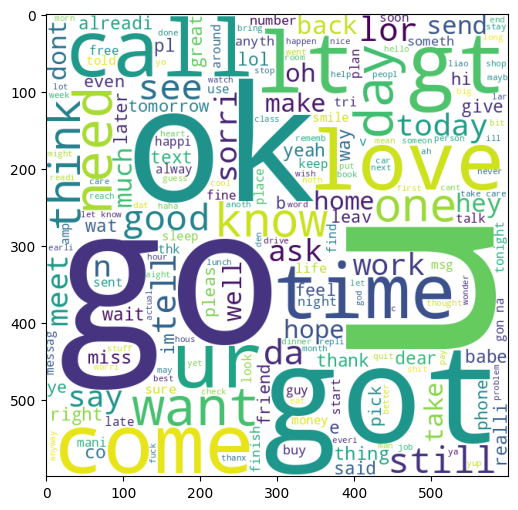

In [32]:
# visualizing the words for ham texts through word cloud
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

Top 30 words coming in spam and ham class

In [33]:
# spam corpus
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
   for word in msg.split():
       spam_corpus.append(word)

len(spam_corpus)

10078

In [34]:
# ham corpus
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

len(ham_corpus)

34545

In [35]:
# top 30 spam words
Counter(spam_corpus).most_common(30)
df_top_30_spam = pd.DataFrame(Counter(spam_corpus).most_common(30))
df_top_30_spam.head(5)

,0,1
0,call,346
1,free,197
2,p,158
3,u,157
4,txt,152


In [36]:
# top 30 ham words
Counter(ham_corpus).most_common(30)
df_top_30_ham = pd.DataFrame(Counter(ham_corpus).most_common(30))
df_top_30_ham.head(5)

,0,1
0,u,915
1,go,397
2,get,351
3,come,273
4,gt,257


**Visualizing 30 most common words in Spam and Normal(ham) emails**  

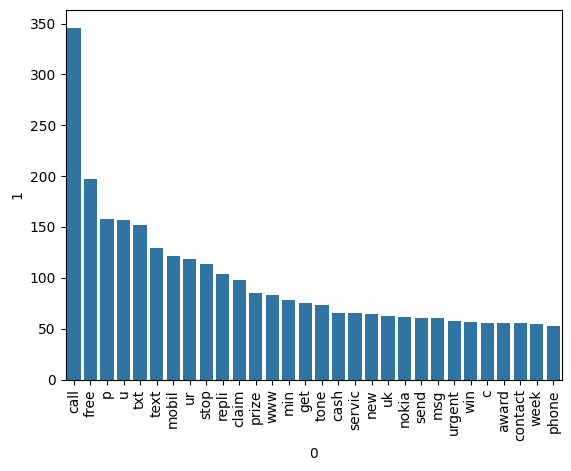

In [37]:
# Below figure shows top 30 spam words in sms
sns.barplot(x = df_top_30_spam[0], y = df_top_30_spam[1])
plt.xticks(rotation='vertical')
plt.show()

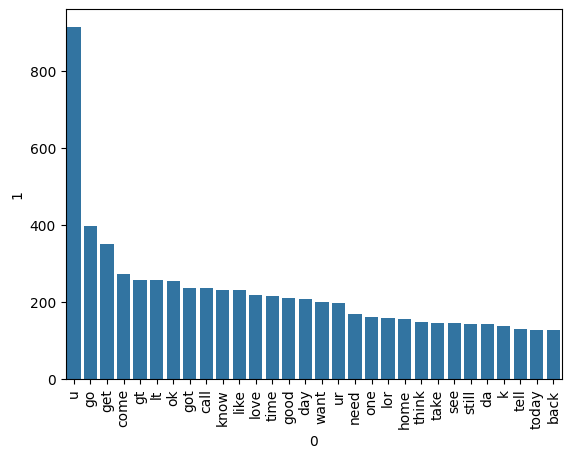

In [38]:
# Below figure shows top 30 ham words in sms
sns.barplot(x=df_top_30_ham[0],y=df_top_30_ham[1])
plt.xticks(rotation='vertical')
plt.show()

## Model Building and text vectorization

In [39]:
# text vectorization using  TfidfVectorizer
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values
print(f"X shape : {X.shape}")
print(f"Y shape : {y.shape}")

X shape : (5149, 6136)
Y shape : (5149,)


**Function to train algorithms**

In [40]:
# function to train algorithms
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)

    return accuracy, precision, confusion_matrix(y_test,y_pred)

**Function to display classifier performance results**

In [41]:
# function to display classifier performance results
def clf_result(name,current_accuracy,current_precision,current_confusion_matrix):
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print("Confusion Matrix - ",current_confusion_matrix)

### 1. Performance  without handling data imbalance

In [42]:
# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [79]:
# Checking the performance without handling data imbalance
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

clfs_NB = {
    'GNB' : gnb,
    'MNB' : mnb,
    'BNB' : bnb
}

for name,clf in clfs_NB.items():

    current_accuracy, current_precision, current_confusion_matrix = train_classifier(clf,X_train,y_train,X_test,y_test)

    clf_result(name,current_accuracy,current_precision,current_confusion_matrix)

For  GNB
Accuracy -  0.870873786407767
Precision -  0.47596153846153844
Confusion Matrix -  [[798 109]
 [ 24  99]]
For  MNB
Accuracy -  0.9689320388349515
Precision -  1.0
Confusion Matrix -  [[907   0]
 [ 32  91]]
For  BNB
Accuracy -  0.9776699029126213
Precision -  0.9545454545454546
Confusion Matrix -  [[902   5]
 [ 18 105]]


* From above, we can say 'MultinomialNB' and 'BernoulliNB' are giving good results i.e having  low False Positives (high Precision) but both have high False Negatives (32 and 18) respectively.
* Drop GaussianNB

* Further checking average baseline performance.

### 2. Average performance without handling data imbalance, using cv = 5

In [43]:
# Average performance without handling data imbalance
mnb = MultinomialNB()
bnb = BernoulliNB()

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, multi_class='ovr')
}

selected_clfs_NB = {
    'MNB' : mnb,
    'BNB' : bnb
}

# iterate over classifier
for name,clf in selected_clfs_NB.items():
  print(f"\n{name}")

  # iterate over metric
  for metric in scoring.keys():
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=metric)

    print(f"Average {metric.capitalize()}:", np.mean(scores))


MNB
Average Accuracy: 0.959700480128349
Average Precision: 0.9972972972972972
Average Recall: 0.6886792452830188
Average F1: 0.8144279697569127
Average Roc_auc: 0.9781609470913353

BNB
Average Accuracy: 0.971109721714306
Average Precision: 0.9680194067272719
Average Recall: 0.8018867924528301
Average F1: 0.8767953074092334
Average Roc_auc: 0.9869358481183497


* Overall Performance: Both models perform well, but BNB shows better accuracy, recall, and F1 score, indicating it is more effective at capturing positive instances while maintaining high precision.
* Trade-offs: MNB has higher precision but lower recall, while BNB balances precision and recall better, making it potentially more suitable for applications where capturing positives is important.

### 3. Average performance with handling data imbalance (manaual - StratifiedKFold and SMOTE)

**Function to handle data imbalance (manaual - StratifiedKFold and SMOTE)**

In [92]:
# function to handle data imbalance
# Iterate over stratified k fold
""" Function takes the input X, y, classifier and apply StratifiedKFold and SMOTE
    to handle imbalanced data and gives the average performance score."""

def handle_imbalance(X,y,clf):
  # creating instances of StratifiedKFold and SMOTE
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
  smote = SMOTE(random_state = 2)

  precision_scores = []
  recall_scores = []
  roc_scores = []

  for train_index, test_index in skf.split(X,y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Apply SMOTE to the training data
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

            # training the classifier over resampled data
            clf.fit(X_train_resampled, y_train_resampled)

            # predictions
            y_pred = clf.predict(X_test)

            # calculate scores at each fold
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            roc_value = roc_auc_score(y_test, y_pred)

            # storing results of each fold
            precision_scores.append(precision)
            recall_scores.append(recall)
            roc_scores.append(roc_value)

  return np.mean(precision_scores), np.mean(recall_scores), np.mean(roc_scores)


In [45]:
# Average performance with handling data imbalance
mnb = MultinomialNB()
bnb = BernoulliNB()

selected_clfs_NB = {
    'MNB' : mnb,
    'BNB' : bnb
}
for name,clf in selected_clfs_NB.items():

      average_precision, average_recall, average_roc_score = handle_imbalance(X,y,clf)

      print(f"\n{name}")
      print(f"Average Precision : {average_precision}")
      print(f"Average Recall : {average_recall}")
      print(f"Average ROC : {average_roc_score}")


MNB
Average Precision : 0.8048394032687252
Average Recall : 0.9341749853200236
Average ROC : 0.9506285877038877

BNB
Average Precision : 0.9913470115967886
Average Recall : 0.8775337639459778
Average ROC : 0.9382109556350825


Using SratifiedKFold and SMOTE to handle data imbalance, we can see :
* Recall score improved for both MNB and BNB.

Precision:
* BNB (0.991) has a significantly higher precision than MNB (0.804). This means BNB is very effective at minimizing false positives, which is crucial in applications where false positives are costly

Recall:

* MNB (0.934) has a higher recall than BNB (0.877). This indicates that MNB captures a larger proportion of actual positives. In contexts like spam detection, high recall is important to ensure that most spam is identified.


### 4. Comparing with other algorithms and selecting out of them.

In [46]:
# Initialize the Models
mnb = MultinomialNB()
bnb = BernoulliNB()
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2)

In [47]:
other_clfs = {
    'MNB' : mnb,
    'BNB' : bnb,
    'SVC' : svc,
    'KN' : knc,
    'LR' : lrc,
    'RF' : rfc,
    'AdaBoost' : abc,
    'ETC' : etc,
    'GBDT' : gbdt,
    'xgb' : xgb
}

In [48]:
# testing other algos performance with StratifiedKFold and SMOTE

compare_precision_scores = []
compare_recall_scores = []
compare_roc_scores = []

for name,clf in other_clfs.items():

      average_precision, average_recall, average_roc_score = handle_imbalance(X,y,clf)

      # storing results in Comparison list
      compare_precision_scores.append(average_precision)
      compare_recall_scores.append(average_recall)
      compare_roc_scores.append(average_roc_score)

      #results
      print(f"\n{name}")
      print(f"Average Precision : {average_precision}")
      print(f"Average Recall : {average_recall}")
      print(f"Average ROC : {average_roc_score}")


MNB
Average Precision : 0.8048394032687252
Average Recall : 0.9341749853200236
Average ROC : 0.9506285877038877

BNB
Average Precision : 0.9913470115967886
Average Recall : 0.8775337639459778
Average ROC : 0.9382109556350825

SVC
Average Precision : 0.9089173224737275
Average Recall : 0.8974163241338815
Average ROC : 0.9421466739937729

KN
Average Precision : 0.9578255005705986
Average Recall : 0.6233352906635349
Average ROC : 0.8096659150141307

LR
Average Precision : 0.8849058463639109
Average Recall : 0.8667645331767471
Average ROC : 0.9251529995014869

RF
Average Precision : 0.9980582524271846
Average Recall : 0.831556077510276
Average ROC : 0.9156669276440269


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1


AdaBoost
Average Precision : 0.900627106130314
Average Recall : 0.8561244862008222
Average ROC : 0.921167668882144

ETC
Average Precision : 0.985976097680983
Average Recall : 0.8667645331767471
Average ROC : 0.9324926361347832

GBDT
Average Precision : 0.7434428198998042
Average Recall : 0.8132706987668821
Average ROC : 0.8861726130096924

xgb
Average Precision : 0.9215102141192848
Average Recall : 0.8775924838520257
Average ROC : 0.9333471009051255


In [49]:
# create performance dataframe
performance_df = pd.DataFrame({'Algorithm':other_clfs.keys(),'Precision':compare_precision_scores, 'Recall' :compare_recall_scores, 'ROC_score':compare_roc_scores}).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Precision,Recall,ROC_score
5,RF,0.998058,0.831556,0.915667
1,BNB,0.991347,0.877534,0.938211
7,ETC,0.985976,0.866765,0.932493
3,KN,0.957826,0.623335,0.809666
9,xgb,0.921510,0.877592,0.933347
2,SVC,0.908917,0.897416,0.942147
6,AdaBoost,0.900627,0.856124,0.921168
4,LR,0.884906,0.866765,0.925153
0,MNB,0.804839,0.934175,0.950629
8,GBDT,0.743443,0.813271,0.886173


* Top Performers: Random Forest (RF), Bernoulli Naive Bayes (BNB), and Extra Trees Classifier (ETC) show the best precision and ROC scores, suggesting they are reliable for classification.

* Recall Focus: MNB has high recall but lower precision, which may be suitable in contexts where capturing all positive cases is crucial, despite potential false positives.

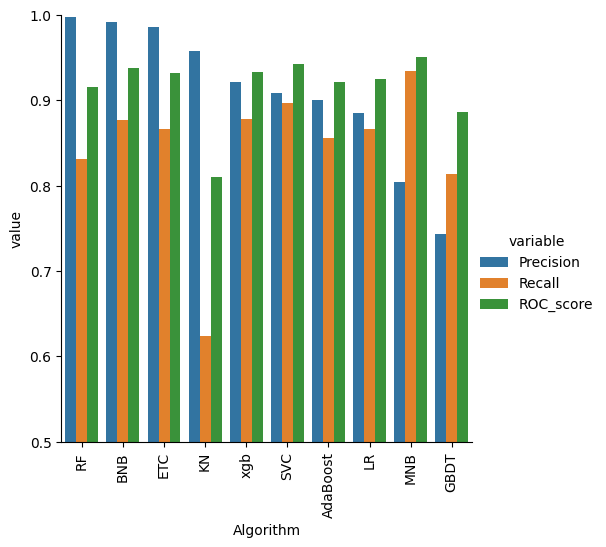

In [52]:
# average performance plot
performance_df1 = pd.melt(performance_df, id_vars="Algorithm")
performance_df1

sns.catplot(x='Algorithm',y='value', hue='variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

* We can check [BNB, RF, ETC] have high average precision score (means low False Positives) but low average Recall scores (means high False Negatives)
* [MNB] has high average Recall score (means it is caputring more true positives) but low average precision score (means it has high False Positives)
* selected_clfs: [BNB, RF, ETC]

### 5. Grid search for max features

In [51]:
# grid search for max features of TfIdf
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
bnb = BernoulliNB()

X = df['transformed_text']
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=2)

skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=2)
smote = SMOTE(random_state=2)

classifiers = {
     'bnb' : bnb,
     'RF' : rfc,
    'ETC' : etc
     }

# parameter grid to search over
param_grid = {
    'tfidf__max_features': [2000, 3000, 4000, 5000, 6000],  # Different values for max_features
    }

results = []

for name, clf in classifiers.items():

   # create a pipeline
   pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('smote', SMOTE(random_state=2)),
        ('classifier', clf)
        ])

   # iterate over metrics
   for scoring in ['precision','recall','roc_auc' ]:
       grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring= scoring)
       grid_search.fit(X_train, y_train)

       # append results to the list
       results.append({
            'Classifier': name,
            'Scoring': scoring,
            'Best Parameters': grid_search.best_params_,
            'Best Cross-Validation Score': grid_search.best_score_
            })

# convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df

,Classifier,Scoring,Best Parameters,Best Cross-Validation Score
0,bnb,precision,{'tfidf__max_features': 5000},0.995810
1,bnb,recall,{'tfidf__max_features': 2000},0.884982
2,bnb,roc_auc,{'tfidf__max_features': 4000},0.991951
3,RF,precision,{'tfidf__max_features': 5000},0.993023
4,RF,recall,{'tfidf__max_features': 2000},0.867839
5,RF,roc_auc,{'tfidf__max_features': 3000},0.986928
6,ETC,precision,{'tfidf__max_features': 4000},0.986926
7,ETC,recall,{'tfidf__max_features': 2000},0.883132
8,ETC,roc_auc,{'tfidf__max_features': 3000},0.985836


Going forward with max_features = 4000

###  ROC plot for different max_features values

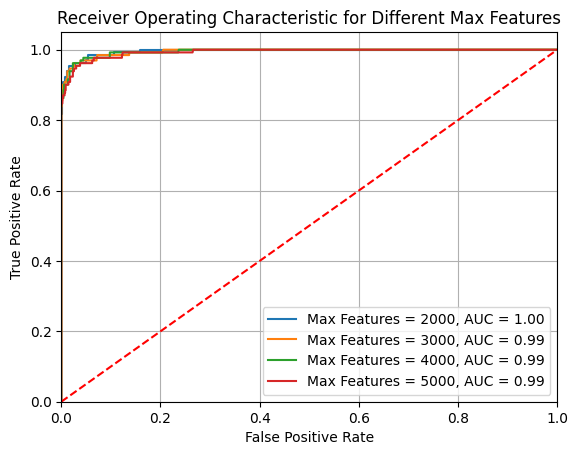

In [62]:
# ROC plot for different max_features values
from sklearn.metrics import roc_curve, auc
# Store ROC AUC scores and probabilities
roc_auc_scores = {}
y_scores = {}

max_features_values = [2000, 3000, 4000, 5000]
# Train and predict for different max_features values
for max_features in max_features_values:
  tfidf = TfidfVectorizer(max_features=max_features)
  X = tfidf.fit_transform(df['transformed_text']).toarray()
  y = df['target'].values
  # Split the dataset while maintaining class distribution
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Create and train the model
  model = BernoulliNB()
  model.fit(X_train, y_train)
  y_score = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve and AUC
  fpr, tpr, _ = roc_curve(y_test, y_score)
  roc_auc = auc(fpr, tpr)

    # Store results
  roc_auc_scores[max_features] = roc_auc
  y_scores[max_features] = (fpr, tpr)

# Plot ROC curves for different max_features values
plt.figure()
for max_features, (fpr, tpr) in y_scores.items():
    plt.plot(fpr, tpr, label=f'Max Features = {max_features}, AUC = {roc_auc_scores[max_features]:.2f}')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Different Max Features')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### 6. TfidfVectorizer(None)

In [68]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

rfc = RandomForestClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
bnb = BernoulliNB()

final_classifiers = {
     'BNB' : bnb,
     'RF' : rfc,
    'ETC' : etc
     }

compare_precision_scores = []
compare_recall_scores = []
compare_roc_scores = []

for name,clf in final_classifiers.items():

      average_precision, average_recall, average_roc_score = handle_imbalance(X,y,clf)

      # storing results in Comparison list
      compare_precision_scores.append(average_precision)
      compare_recall_scores.append(average_recall)
      compare_roc_scores.append(average_roc_score)



In [71]:
# create performance dataframe
performance_df = pd.DataFrame({'Algorithm':final_classifiers.keys(),'Precision':compare_precision_scores, 'Recall' :compare_recall_scores, 'ROC_score':compare_roc_scores}).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Precision,Recall,ROC_score
1,RF,0.998058,0.831556,0.915667
0,BNB,0.991347,0.877534,0.938211
2,ETC,0.985976,0.866765,0.932493


### Comparision of performane with diff max features and weights

In [ ]:
4000
[1, 1, 1]
Average Precision : 0.9982300884955752
Average Recall : 0.8760070463887258
Average ROC : 0.9378929037253364

4000
[2, 1, 1]
Average Precision : 0.9965517241379309
Average Recall : 0.8759953024075162
Average ROC : 0.937776412265705

3000
[1, 1, 1]
Average Precision : 0.9949152542372882
Average Recall : 0.8852025836758661
Average ROC : 0.9422694334308535

3000
[2, 1, 1]
Average Precision : 0.9949152542372882
Average Recall : 0.8852025836758661
Average ROC : 0.9422694334308535


5000
[2, 1, 1]
Average Precision : 0.9982300884955752
Average Recall : 0.8515091015854374
Average ROC : 0.9256439313236923




## Model Improvement

1. Change the max_features parameter of TfIdf
   max_features = 4000   (Improved)
2. Scalling X, MinMaxScalar (no effect)
3. Added Custom Feature to X, (no effect)
4. Voting Classifier

### 1. Changing the max_features parameter of TfIdf

In [72]:
tfidf = TfidfVectorizer(max_features=4000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

rfc = RandomForestClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
bnb = BernoulliNB()

final_classifiers = {
     'BNB' : bnb,
     'RF' : rfc,
    'ETC' : etc
     }

compare_precision_scores = []
compare_recall_scores = []
compare_roc_scores = []

for name,clf in final_classifiers.items():

      average_precision, average_recall, average_roc_score = handle_imbalance(X,y,clf)

      # storing results in Comparison list
      compare_precision_scores.append(average_precision)
      compare_recall_scores.append(average_recall)
      compare_roc_scores.append(average_roc_score)



In [73]:
# create performance dataframe
temp_df1 = pd.DataFrame({'Algorithm':final_classifiers.keys(),'Precision_max_ft_4000':compare_precision_scores, 'Recall_max_ft_4000' :compare_recall_scores, 'ROC_score_max_ft_4000':compare_roc_scores}).sort_values('Precision_max_ft_4000',ascending=False)
temp_df1

,Algorithm,Precision_max_ft_4000,Recall_max_ft_4000,ROC_score_max_ft_4000
0,BNB,0.991375,0.880599,0.939744
1,RF,0.987385,0.846894,0.922668
2,ETC,0.984546,0.882090,0.940044


In [74]:
new_df = performance_df.merge(temp_df1,on='Algorithm')
new_df

,Algorithm,Precision,Recall,ROC_score,Precision_max_ft_4000,Recall_max_ft_4000,ROC_score_max_ft_4000
0,RF,0.998058,0.831556,0.915667,0.987385,0.846894,0.922668
1,BNB,0.991347,0.877534,0.938211,0.991375,0.880599,0.939744
2,ETC,0.985976,0.866765,0.932493,0.984546,0.882090,0.940044


### 2. Scaling of input

In [83]:
scaler = MinMaxScaler()

tfidf = TfidfVectorizer(max_features = 4000)
X = tfidf.fit_transform(df['transformed_text']).toarray()

y = df['target'].values


compare_precision_scores = []
compare_recall_scores = []
compare_roc_scores = []

for name,clf in final_classifiers.items():

    precision_scores = []
    recall_scores = []
    roc_scores = []

    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Apply SMOTE to the training data
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        # Scaling the resampled input
        X_train_resampled = scaler.fit_transform(X_train_resampled)
        X_test = scaler.transform(X_test)
        # training the classifier over resampled data
        clf.fit(X_train_resampled, y_train_resampled)
        # predictions
        y_pred = clf.predict(X_test)

        # calculate scores at each fold
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_value = roc_auc_score(y_test, y_pred)

        # storing results of each fold
        precision_scores.append(precision)
        recall_scores.append(recall)
        roc_scores.append(roc_value)

        average_precision = np.mean(precision_scores)
        average_recall = np.mean(recall_scores)
        average_roc_score = np.mean(roc_scores)


    # storing results in Comparison list
    compare_precision_scores.append(average_precision)
    compare_recall_scores.append(average_recall)
    compare_roc_scores.append(average_roc_score)


In [88]:
# create performance dataframe
temp_df2 = pd.DataFrame({'Algorithm':final_classifiers.keys(),'Precision_scaling':compare_precision_scores, 'Recall_scaling' :compare_recall_scores, 'ROC_score_scaling':compare_roc_scores}).sort_values('Precision_scaling',ascending=False)
temp_df2

,Algorithm,Precision_scaling,Recall_scaling,ROC_score_scaling
0,BNB,0.991375,0.880599,0.939744
1,RF,0.987385,0.846894,0.922668
2,ETC,0.984546,0.882090,0.940044


In [89]:
new_scaled_df = new_df.merge(temp_df2,on='Algorithm')
new_scaled_df

,Algorithm,Precision,Recall,ROC_score,Precision_max_ft_4000,Recall_max_ft_4000,ROC_score_max_ft_4000,Precision_scaling,Recall_scaling,ROC_score_scaling
0,RF,0.998058,0.831556,0.915667,0.987385,0.846894,0.922668,0.987385,0.846894,0.922668
1,BNB,0.991347,0.877534,0.938211,0.991375,0.880599,0.939744,0.991375,0.880599,0.939744
2,ETC,0.985976,0.866765,0.932493,0.984546,0.882090,0.940044,0.984546,0.882090,0.940044


### 3. Appending num_characters col to X

In [78]:
tfidf = TfidfVectorizer(max_features = 4000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
X = np.hstack((X,df['num_characters'].values.reshape(-1,1)))

y = df['target'].values



compare_precision_scores = []
compare_recall_scores = []
compare_roc_scores = []

for name,clf in final_classifiers.items():

      average_precision, average_recall, average_roc_score = handle_imbalance(X,y,clf)

      # storing results in Comparison list
      compare_precision_scores.append(average_precision)
      compare_recall_scores.append(average_recall)
      compare_roc_scores.append(average_roc_score)

In [79]:
temp_df3 = pd.DataFrame({'Algorithm':final_classifiers.keys(), 'Precision_num_chars':compare_precision_scores, 'Recall_num_chars' :compare_recall_scores, 'ROC_score_num_chars':compare_roc_scores}).sort_values('Precision_num_chars',ascending=False)


### final_performance_df

In [90]:
final_performance_df = new_scaled_df.merge(temp_df3,on='Algorithm')
final_performance_df

,Algorithm,Precision,Recall,ROC_score,Precision_max_ft_4000,Recall_max_ft_4000,ROC_score_max_ft_4000,Precision_scaling,Recall_scaling,ROC_score_scaling,Precision_num_chars,Recall_num_chars,ROC_score_num_chars
0,RF,0.998058,0.831556,0.915667,0.987385,0.846894,0.922668,0.987385,0.846894,0.922668,0.987889,0.872918,0.935681
1,BNB,0.991347,0.877534,0.938211,0.991375,0.880599,0.939744,0.991375,0.880599,0.939744,0.994495,0.846905,0.923119
2,ETC,0.985976,0.866765,0.932493,0.984546,0.882090,0.940044,0.984546,0.882090,0.940044,0.978155,0.888221,0.942665


* Recall improved using max_features= 4000.
* There is no effect on performance by Scaling.
* BNB is having high Precision score comparitively.


### 4. Voting Classifier

In [91]:
# Equal weights for all classifiers


# Text vectorization
tfidf = TfidfVectorizer(max_features = 4000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

# estimators
estimators = [('BNB', bnb), ('ETC', etc), ('RF', rfc)]
voting_clf = VotingClassifier(estimators = estimators,voting = 'soft')
clf = voting_clf

average_precision, average_recall, average_roc_score = handle_imbalance(X,y,clf)

print(f'Average Precision: {average_precision}')
print(f'Average Recall: {average_recall}')
print(f'Average ROC: {average_roc_score}')


Average Precision: 0.9948275862068966
Average Recall: 0.88825601879037
Average ROC: 0.9437945524677346


### Choosing the Right Model:
* The choice between the models depends on the context of application:
* Average Precision: 0.9948
This indicates a high level of precision, meaning that when your model predicts a positive class, it is very likely to be correct. In other words, there are very few false positives.

* Average Recall: 0.8883

This suggests that the model is good at identifying positive instances but still misses some (i.e., it has some false negatives). A recall of around 88.83% is generally considered good, but there’s room for improvement, especially if capturing all positive cases is crucial.
*
Average ROC AUC: 0.9438

A ROC AUC score close to 1 indicates that the model does a great job of distinguishing between the positive and negative classes. An AUC of 0.9438 suggests that the model is very effective, with a strong ability to differentiate between classes.

* Since we want to keep Precision high to keep false positives low so that we don't misclassify an important email while keeping Recall relevant to capture most of the true positives,
will select :  
 * max_features = 4000
 * voting weights for [BNB, ETC, RFC] : [1,1,1]

* Although these parameters can be different depending on our end goal i.e. if we want to focus more on capturing ture positives (aiming for high Recall).


## Final Model
Our final model include:
* TfIDF vectorizer with max features = 4000
* VotingClassifier with estimators:
  * MultiNomialNB
  * RandomForestClassifer
  * ExtraTreeClassifier


In [93]:
# Final Pipeline
rfc = RandomForestClassifier(n_estimators = 50, random_state = 2)
etc = ExtraTreesClassifier(n_estimators = 50, random_state = 2)
bnb = BernoulliNB()
voting_clf = VotingClassifier(estimators=[('rfc', rfc), ('etc', etc), ('bnb', bnb)], voting='soft')

# Split the data into training and testing sets
X = df['transformed_text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

# StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)


pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=4000)),
    ('smote', SMOTE(random_state=2)),  # Handle class imbalance
    ('voting', voting_clf)  # Final estimator
])

# Perform cross-validation to evaluate the final pipeline
for metric in ['precision','recall', 'roc_auc']:
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring = metric)

    print(f"Average {metric.capitalize()}:", np.mean(scores))

# Fit the pipeline on training set after cross-validation
pipeline.fit(X_train, y_train)

# Testing the pipeline
y_pred = pipeline.predict(X_test)

# Pipeline classification_report
print(classification_report(y_test, y_pred))


Average Precision: 0.9978260869565216
Average Recall: 0.8715567765567765
Average Roc_auc: 0.9886681911138622
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       899
           1       0.99      0.87      0.93       131

    accuracy                           0.98      1030
   macro avg       0.99      0.93      0.96      1030
weighted avg       0.98      0.98      0.98      1030



In [95]:
# creating pickle file
# objects and their corresponding filenames
objects = [
    (transform_text, 'text_transformer.pkl'),
    (pipeline, 'pipeline_rf_etc_bnb.pkl')
]

for obj, filename in objects:
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

In [96]:
# Download the pickled file
from google.colab import files
files.download('text_transformer.pkl')
files.download('pipeline_rf_etc_bnb.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>